<div style="text-align:center">
    <h1>
        Value Iteration
    </h1>
</div>
<br>

<div style="text-align:center">
    <p>
        In this notebook we are going to look at a dynamic programming algorithm called value iteration. In it, we will sweep the state space and update all the V(s) values.
    </p>
</div>

In [1]:
# @title Setup code (not important) - Run this cell by pressing "Shift + Enter"



!pip install -qq gym==0.23.0


from typing import Tuple, Dict, Optional, Iterable, Callable

import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import animation

from IPython.display import HTML

import gym
from gym import spaces
from gym.error import DependencyNotInstalled

import pygame
from pygame import gfxdraw


class Maze(gym.Env):

    def __init__(self, exploring_starts: bool = False,
                 shaped_rewards: bool = False, size: int = 5) -> None:
        super().__init__()
        self.exploring_starts = exploring_starts
        self.shaped_rewards = shaped_rewards
        self.state = (size - 1, size - 1)
        self.goal = (size - 1, size - 1)
        self.maze = self._create_maze(size=size)
        self.distances = self._compute_distances(self.goal, self.maze)
        self.action_space = spaces.Discrete(n=4)
        self.action_space.action_meanings = {0: 'UP', 1: 'RIGHT', 2: 'DOWN', 3: "LEFT"}
        self.observation_space = spaces.MultiDiscrete([size, size])

        self.screen = None
        self.agent_transform = None

    def step(self, action: int) -> Tuple[Tuple[int, int], float, bool, Dict]:
        reward = self.compute_reward(self.state, action)
        self.state = self._get_next_state(self.state, action)
        done = self.state == self.goal
        info = {}
        return self.state, reward, done, info

    def reset(self) -> Tuple[int, int]:
        if self.exploring_starts:
            while self.state == self.goal:
                self.state = tuple(self.observation_space.sample())
        else:
            self.state = (0, 0)
        return self.state

    def render(self, mode: str = 'human') -> Optional[np.ndarray]:
        assert mode in ['human', 'rgb_array']

        screen_size = 600
        scale = screen_size / 5

        if self.screen is None:
            pygame.init()
            self.screen = pygame.Surface((screen_size, screen_size))

        surf = pygame.Surface((screen_size, screen_size))
        surf.fill((22, 36, 71))


        for row in range(5):
            for col in range(5):

                state = (row, col)
                for next_state in [(row + 1, col), (row - 1, col), (row, col + 1), (row, col - 1)]:
                    if next_state not in self.maze[state]:

                        # Add the geometry of the edges and walls (i.e. the boundaries between
                        # adjacent squares that are not connected).
                        row_diff, col_diff = np.subtract(next_state, state)
                        left = (col + (col_diff > 0)) * scale - 2 * (col_diff != 0)
                        right = ((col + 1) - (col_diff < 0)) * scale + 2 * (col_diff != 0)
                        top = (5 - (row + (row_diff > 0))) * scale - 2 * (row_diff != 0)
                        bottom = (5 - ((row + 1) - (row_diff < 0))) * scale + 2 * (row_diff != 0)

                        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (255, 255, 255))

        # Add the geometry of the goal square to the viewer.
        left, right, top, bottom = scale * 4 + 10, scale * 5 - 10, scale - 10, 10
        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (40, 199, 172))

        # Add the geometry of the agent to the viewer.
        agent_row = int(screen_size - scale * (self.state[0] + .5))
        agent_col = int(scale * (self.state[1] + .5))
        gfxdraw.filled_circle(surf, agent_col, agent_row, int(scale * .6 / 2), (228, 63, 90))

        surf = pygame.transform.flip(surf, False, True)
        self.screen.blit(surf, (0, 0))

        return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def close(self) -> None:
        if self.screen is not None:
            pygame.display.quit()
            pygame.quit()
            self.screen = None

    def compute_reward(self, state: Tuple[int, int], action: int) -> float:
        next_state = self._get_next_state(state, action)
        if self.shaped_rewards:
            return - (self.distances[next_state] / self.distances.max())
        return - float(state != self.goal)

    def simulate_step(self, state: Tuple[int, int], action: int):
        reward = self.compute_reward(state, action)
        next_state = self._get_next_state(state, action)
        done = next_state == self.goal
        info = {}
        return next_state, reward, done, info

    def _get_next_state(self, state: Tuple[int, int], action: int) -> Tuple[int, int]:
        if action == 0:
            next_state = (state[0] - 1, state[1])
        elif action == 1:
            next_state = (state[0], state[1] + 1)
        elif action == 2:
            next_state = (state[0] + 1, state[1])
        elif action == 3:
            next_state = (state[0], state[1] - 1)
        else:
            raise ValueError("Action value not supported:", action)
        if next_state in self.maze[state]:
            return next_state
        return state

    @staticmethod
    def _create_maze(size: int) -> Dict[Tuple[int, int], Iterable[Tuple[int, int]]]:
        maze = {(row, col): [(row - 1, col), (row + 1, col), (row, col - 1), (row, col + 1)]
                for row in range(size) for col in range(size)}

        left_edges = [[(row, 0), (row, -1)] for row in range(size)]
        right_edges = [[(row, size - 1), (row, size)] for row in range(size)]
        upper_edges = [[(0, col), (-1, col)] for col in range(size)]
        lower_edges = [[(size - 1, col), (size, col)] for col in range(size)]
        walls = [
            [(1, 0), (1, 1)], [(2, 0), (2, 1)], [(3, 0), (3, 1)],
            [(1, 1), (1, 2)], [(2, 1), (2, 2)], [(3, 1), (3, 2)],
            [(3, 1), (4, 1)], [(0, 2), (1, 2)], [(1, 2), (1, 3)],
            [(2, 2), (3, 2)], [(2, 3), (3, 3)], [(2, 4), (3, 4)],
            [(4, 2), (4, 3)], [(1, 3), (1, 4)], [(2, 3), (2, 4)],
        ]

        obstacles = upper_edges + lower_edges + left_edges + right_edges + walls

        for src, dst in obstacles:
            maze[src].remove(dst)

            if dst in maze:
                maze[dst].remove(src)

        return maze

    @staticmethod
    def _compute_distances(goal: Tuple[int, int],
                           maze: Dict[Tuple[int, int], Iterable[Tuple[int, int]]]) -> np.ndarray:
        distances = np.full((5, 5), np.inf)
        visited = set()
        distances[goal] = 0.

        while visited != set(maze):
            sorted_dst = [(v // 5, v % 5) for v in distances.argsort(axis=None)]
            closest = next(x for x in sorted_dst if x not in visited)
            visited.add(closest)

            for neighbour in maze[closest]:
                distances[neighbour] = min(distances[neighbour], distances[closest] + 1)
        return distances


def plot_policy(probs_or_qvals, frame, action_meanings=None):
    if action_meanings is None:
        action_meanings = {0: 'U', 1: 'R', 2: 'D', 3: 'L'}
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    max_prob_actions = probs_or_qvals.argmax(axis=-1)
    probs_copy = max_prob_actions.copy().astype(object)
    for key in action_meanings:
        probs_copy[probs_copy == key] = action_meanings[key]
    sns.heatmap(max_prob_actions, annot=probs_copy, fmt='', cbar=False, cmap='coolwarm',
                annot_kws={'weight': 'bold', 'size': 12}, linewidths=2, ax=axes[0])
    axes[1].imshow(frame)
    axes[0].axis('off')
    axes[1].axis('off')
    plt.suptitle("Policy", size=18)
    plt.tight_layout()


def plot_values(state_values, frame):
    f, axes = plt.subplots(1, 2, figsize=(10, 4))
    sns.heatmap(state_values, annot=True, fmt=".2f", cmap='coolwarm',
                annot_kws={'weight': 'bold', 'size': 12}, linewidths=2, ax=axes[0])
    axes[1].imshow(frame)
    axes[0].axis('off')
    axes[1].axis('off')
    plt.tight_layout()


def display_video(frames):
    # Copied from: https://colab.research.google.com/github/deepmind/dm_control/blob/master/tutorial.ipynb
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    matplotlib.use(orig_backend)
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
        im.set_data(frame)
        return [im]
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                    interval=50, blit=True, repeat=False)
    return HTML(anim.to_html5_video())


def test_agent(environment, policy, episodes=10):
    frames = []
    for episode in range(episodes):
        state = env.reset()
        done = False
        frames.append(env.render(mode="rgb_array"))

        while not done:
            p = policy(state)
            if isinstance(p, np.ndarray):
                action = np.random.choice(4, p=p)
            else:
                action = p
            next_state, reward, done, extra_info = env.step(action)
            img = env.render(mode="rgb_array")
            frames.append(img)
            state = next_state

    return display_video(frames)



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.4/624.4 kB 7.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Import the necessary software libraries:

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Initialize the environment

In [3]:
env = Maze()

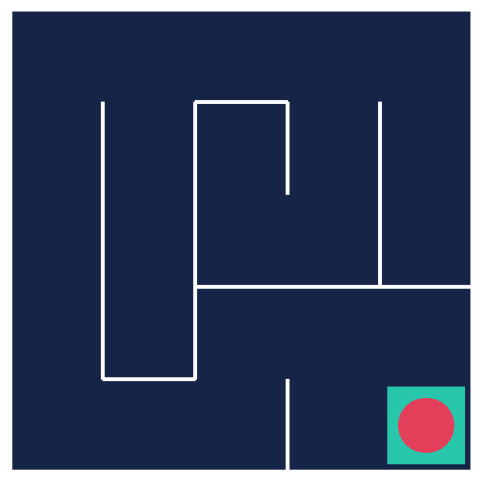

In [6]:
frame = env.render(mode='rgb_array') # Para que lo devuelva como un array de numpy
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(frame)

In [7]:
print(f"Observation space shape: {env.observation_space.nvec}")
print(f"Number of actions: {env.action_space.n}")

Observation space shape: [5 5]
Number of actions: 4


## Define the policy $\pi(\cdot|s)$

#### Create the policy $\pi(\cdot|s)$

In [8]:
# Crear una tabla de valores que contenga la probabilidad de tomar
# cada acción en cada estado

#tabla 5x5 y 4 posibles acciones [0.25, 0.25, 0.25, 0.25]
policy_probs = np.full((5, 5, 4), 0.25)

In [12]:
#La política toma como input un estado y devuelve las probabilidades de ejecutar
# cada unas de las acciones que tiene disponible

#El estado es una tupla de dos valores fila y columna que vamos a utilizar
# para buscar en la tabla las probabilidades
def policy(state):
    return policy_probs[state]

#### Test the policy with state (0, 0)

In [13]:
# Vamos a buscar los valores del estado 0,0 es decir del estado inicial

action_probabilities = policy((0,0))
for action, prob in zip(range(4), action_probabilities):
    print(f"Probability of taking action {action}: {prob}")

Probability of taking action 0: 0.25
Probability of taking action 1: 0.25
Probability of taking action 2: 0.25
Probability of taking action 3: 0.25


#### See how the random policy does in the maze

In [14]:
# Ahora vamos a hacer que un agente se enfrente al entorno con esa política
# Queremos testearlo durante un episodio

test_agent(env, policy, episodes=1)

#### Plot the policy

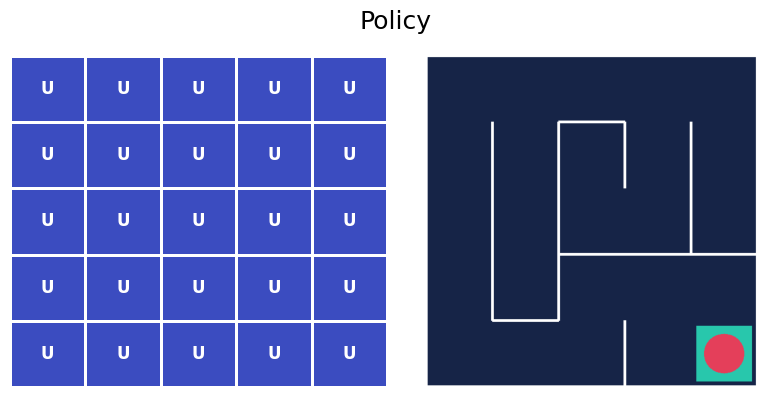

In [15]:
plot_policy(policy_probs, frame)

## Define value table $V(s)$

#### Create the $V(s)$ table

Creando la tabla de valores con una entrada para cada estado y la vamos a representar gráficamente con el método plot_values

In [17]:
state_values = np.zeros(shape=(5,5))

#### Plot V(s)

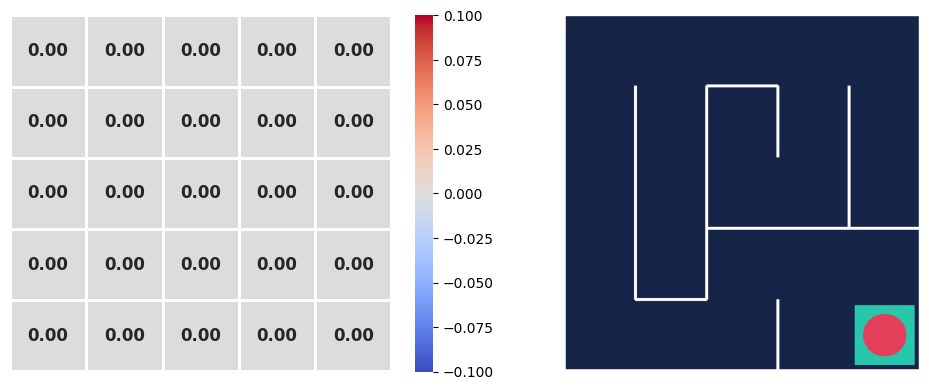

In [18]:
plot_values(state_values, frame)

## Implement the Value Iteration algorithm

</br>




<div style="text-align:center">
    Adapted from Barto & Sutton: "Reinforcement Learning: An Introduction".
</div>

In [20]:
# Algoritmo iteración de valor

# Le enviamos la tabla de probabilidades de la política
# tabla del valor de los estados
# theta como una constante muy pequeña va a decidir cuando paramos de actualizar los valores
# Un valor gamma para calcular el retorno esperado
def value_iteration(policy_probs, state_values, theta=1e-6, gamma=0.99):
    delta = float('inf')

    while delta > theta:
        delta = 0
        for row in range(5):
            for col in range(5):
                old_value = state_values[(row, col)]
                action_probs = None
                max_qsa = float('-inf') # donde guardaremos el mayor valor encontrado de entre todas las acciones disponibles

                #iteramos en cada una de las 4 acciones disponibles
                for action in range(4):
                    next_state, reward, _, _ = env.simulate_step((row, col), action)
                    qsa = reward + gamma * state_values[next_state] #Valor de esa acción #Descontado por gamma
                    if qsa > max_qsa:
                        max_qsa = qsa
                        action_probs = np.zeros(4) #Inicializamos las probabiliades como un vector de 4 ceros un cero para cada acción
                        action_probs[action] = 1. # Le asignamos un 1 para que se convierta en un 100%

                #Actualizamos el valor de este estado, indexamos con los valores fila y columna
                # y a esta entrada de la tabla le vamos a asignar el valor de la acción óptima
                state_values[(row, col)] = max_qsa

                # A la tabla de probabilidades de la política
                # En la entrada para este estado vamos a hacer que tenga un 100% de probabilidades que tenga
                # para escoger la acción óptima
                policy_probs[(row, col)] = action_probs

                # Ahora debemos actualizar el valor de delta si el cambio entre el valor
                # antiguo y el valor nuevo de este estado es mayor al valor antiguo de delta
                # Entre el máximo entre dos valores: El valor antiguo y el valor antiguo para el valor de este estado
                delta = max(delta, abs(max_qsa - old_value))



In [21]:
value_iteration(policy_probs, state_values)

## Show results

#### Show resulting value table $V(s)$

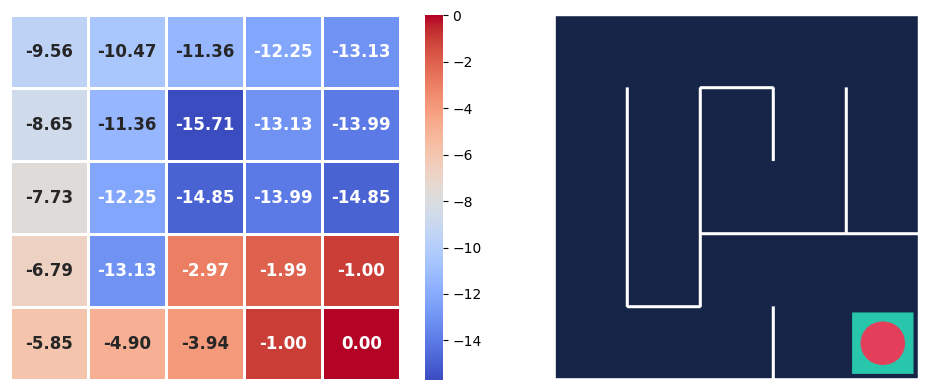

In [22]:
plot_values(state_values, frame)

# El valor de un estado es el retorno que esperamos obtener -9.56

#### Show resulting policy $\pi(\cdot|s)$

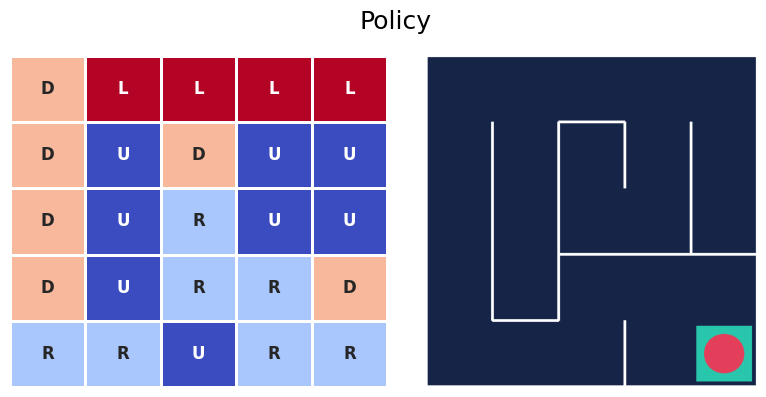

In [23]:
plot_policy(policy_probs, frame)

# Desde el estado inicial las acciones óptimas consisten en bajar derecha, subir derecha y llegar a la meta.
# Que nos llevan a la meta a partir de cualquier estado

#### Test the resulting agent

In [24]:
#El agente es capaz de encontrar la salida con la menor cantidad de
#movimientos posibles

test_agent(env, policy)

## Resources

[[1] Reinforcement Learning: An Introduction. Ch. 4: Dynamic Programming](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf)